<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250723/%E6%9C%80%E5%B0%8F%E8%B2%BB%E7%94%A8%E6%B5%81%E5%95%8F%E9%A1%8C%E3%81%AE%E6%BC%94%E7%BF%92%E5%95%8F%E9%A1%8C%E3%81%AE%E8%A7%A3%E7%AD%94%E3%81%A8%E8%A7%A3%E8%AA%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#演習問題 解答（最小費用流問題）

#### **準備**


In [ ]:
%%capture
# ライブラリのインストール
!pip install mip
!pip install japanize-matplotlib

-----
# **演習問題1**

基本例のアーク (F2, W2) の単位費用を1から5に増加させ、同時にアーク (W1, C1) の容量を40から60に増加させたとします。総費用の最小値を求めよ。

##Python (MIP) による実装


In [ ]:
import pandas as pd
from mip import Model, xsum, minimize, CONTINUOUS, OptimizationStatus

# --- データ定義 ---
# ノード名とバランス（供給/需要）
node_names = ['F1', 'F2', 'W1', 'W2', 'C1', 'C2', 'C3']
balances = {'F1': 100, 'F2': 80, 'W1': 0, 'W2': 0, 'C1': -70, 'C2': -50, 'C3': -60}

# アークデータ: (始点, 終点, 費用, 容量)
# (F2, W2)の費用を1から5に、(W1, C1)の容量を40から60に変更
arcs_data = [
    ('F1', 'W1', 2, 70), ('F1', 'W2', 3, 50),
    ('F2', 'W1', 4, 60), ('F2', 'W2', 5, 50),  # 費用を変更
    ('W1', 'C1', 3, 60), ('W1', 'C2', 5, 30), ('W1', 'C3', 4, 40), # 容量を変更
    ('W2', 'C1', 2, 50), ('W2', 'C2', 1, 40), ('W2', 'C3', 3, 30),
    ('F1', 'C1', 10, 20), ('F2', 'C3', 12, 20)
]

# アークの集合、費用、容量を辞書型に変換
defined_arcs = [(u, v) for u, v, cost, cap in arcs_data]
costs = {(u, v): cost for u, v, cost, cap in arcs_data}
capacities = {(u, v): cap for u, v, cost, cap in arcs_data}

# --- モデル作成 ---
model = Model("MinCostFlow_Ex1")

# --- 決定変数 ---
# x[i,j] はアーク(i,j)上のフロー量
x = {(i, j): model.add_var(name=f"x_{i}_{j}", lb=0, ub=capacities[i, j], var_type=CONTINUOUS)
     for (i, j) in defined_arcs}

# --- 目的関数 ---
# 総輸送費用の最小化
model.objective = minimize(xsum(costs[i, j] * x[i, j] for (i, j) in defined_arcs))

# --- 制約条件 ---
# フロー保存則
for k in node_names:
    flow_out = xsum(x[i, j] for (i, j) in defined_arcs if i == k)
    flow_in = xsum(x[i, j] for (i, j) in defined_arcs if j == k)
    model += (flow_out - flow_in == balances[k], f"FlowBalance_{k}")

# --- 最適化の実行 ---
status = model.optimize()

# --- 結果の表示 ---
if status == OptimizationStatus.OPTIMAL:
    print(f"最適解が見つかりました。")
    print(f"総費用: {model.objective_value:.2f}")
    print("\n最適フロー:")
    for (i, j) in defined_arcs:
        if x[i, j].x > 1e-6: # 無視できるほど小さいフローは表示しない
            print(f"  アーク ({i} -> {j}): {x[i, j].x:.2f} ユニット")
elif status == OptimizationStatus.INFEASIBLE:
    print("実行不可能な問題です。制約を満たす解が存在しません。")
else:
    print(f"最適化が停止しました。ステータス: {status}")

最適解が見つかりました。
総費用: 1100.00

最適フロー:
  アーク (F1 -> W1): 70.00 ユニット
  アーク (F1 -> W2): 30.00 ユニット
  アーク (F2 -> W1): 40.00 ユニット
  アーク (F2 -> W2): 40.00 ユニット
  アーク (W1 -> C1): 60.00 ユニット
  アーク (W1 -> C2): 10.00 ユニット
  アーク (W1 -> C3): 40.00 ユニット
  アーク (W2 -> C1): 10.00 ユニット
  アーク (W2 -> C2): 40.00 ユニット
  アーク (W2 -> C3): 20.00 ユニット


-----

# **演習問題2**

基本例のネットワークに、新たに倉庫W1から倉庫W2への輸送ルート (W1, W2) を追加することを考えます。この新しいルートの単位費用は0、容量は30であるとします。総費用の最小値を求めよ。

##Python (MIP) による実装

基本例の `arcs_data` リストに、
に新しいアーク $(W1, W2)$ を追加する。他のパラメータは基本例と同一である。


In [ ]:
import pandas as pd
from mip import Model, xsum, minimize, CONTINUOUS, OptimizationStatus

# --- データ定義 ---
# ノード名とバランス（供給/需要）
node_names = ['F1', 'F2', 'W1', 'W2', 'C1', 'C2', 'C3']
balances = {'F1': 100, 'F2': 80, 'W1': 0, 'W2': 0, 'C1': -70, 'C2': -50, 'C3': -60}

# アークデータ: (始点, 終点, 費用, 容量)
# 新しいアーク (W1, W2) を追加
arcs_data = [
    ('F1', 'W1', 2, 70), ('F1', 'W2', 3, 50),
    ('F2', 'W1', 4, 60), ('F2', 'W2', 1, 50),
    ('W1', 'C1', 3, 40), ('W1', 'C2', 5, 30), ('W1', 'C3', 4, 40),
    ('W2', 'C1', 2, 50), ('W2', 'C2', 1, 40), ('W2', 'C3', 3, 30),
    ('F1', 'C1', 10, 20), ('F2', 'C3', 12, 20),
    ('W1', 'W2', 0, 30)  # 新しいアークを追加
]

# アークの集合、費用、容量を辞書型に変換
defined_arcs = [(u, v) for u, v, cost, cap in arcs_data]
costs = {(u, v): cost for u, v, cost, cap in arcs_data}
capacities = {(u, v): cap for u, v, cost, cap in arcs_data}

# --- モデル作成 ---
model = Model("MinCostFlow_Ex2")

# --- 決定変数 ---
x = {(i, j): model.add_var(name=f"x_{i}_{j}", lb=0, ub=capacities[i, j], var_type=CONTINUOUS)
     for (i, j) in defined_arcs}

# --- 目的関数 ---
model.objective = minimize(xsum(costs[i, j] * x[i, j] for (i, j) in defined_arcs))

# --- 制約条件 ---
for k in node_names:
    model += (xsum(x[i, j] for (i, j) in defined_arcs if i == k) -
              xsum(x[i, j] for (i, j) in defined_arcs if j == k) == balances[k],
              f"FlowBalance_{k}")

# --- 最適化の実行 ---
status = model.optimize()

# --- 結果の表示 ---
if status == OptimizationStatus.OPTIMAL:
    print(f"最適解が見つかりました。")
    print(f"総費用: {model.objective_value:.2f}")
    print("\n最適フロー:")
    for (i, j) in defined_arcs:
        if x[i, j].x > 1e-6:
            print(f"  アーク ({i} -> {j}): {x[i, j].x:.2f} ユニット")
elif status == OptimizationStatus.INFEASIBLE:
    print("実行不可能な問題です。制約を満たす解が存在しません。")
else:
    print(f"最適化が停止しました。ステータス: {status}")

最適解が見つかりました。
総費用: 870.00

最適フロー:
  アーク (F1 -> W1): 70.00 ユニット
  アーク (F1 -> W2): 30.00 ユニット
  アーク (F2 -> W1): 30.00 ユニット
  アーク (F2 -> W2): 50.00 ユニット
  アーク (W1 -> C1): 20.00 ユニット
  アーク (W1 -> C2): 10.00 ユニット
  アーク (W1 -> C3): 40.00 ユニット
  アーク (W2 -> C1): 50.00 ユニット
  アーク (W2 -> C2): 40.00 ユニット
  アーク (W2 -> C3): 20.00 ユニット
  アーク (W1 -> W2): 30.00 ユニット


---
#**演習問題3**

基本例において、顧客C1の需要量を-70から-100に増加させ、かつアーク (F1,W1) の容量を70から30に減少させたとします。他の条件は例題と同じとする。最適化を行い総費用の最小値を求めよ。最適値が無い場合は0と解答すること。

##考え方

この問題では、ノードバランスとアーク容量が変更される。
ここで、ネットワーク全体のバランスを確認すると、

* 総供給量: $b_{F1} + b_{F2} = 100 + 80 = 180$
* 総需要量: $|b_{C1}| + |b_{C2}| + |b_{C3}| = 100 + 50 + 60 = 210$

となり、総供給量 \< 総需要量 となる。このため、全ての需要を満たすことは不可能であり、フロー保存則を満たす実行可能な解は存在しないと予想される。

##Python (MIP) による実装

変更されたパラメータを反映してモデルを構築し、MIPソルバーの結果を確認する。


In [ ]:
import pandas as pd
from mip import Model, xsum, minimize, CONTINUOUS, OptimizationStatus

# --- データ定義 ---
# ノード名とバランス（供給/需要）
node_names = ['F1', 'F2', 'W1', 'W2', 'C1', 'C2', 'C3']
# C1の需要を-100に変更
balances = {'F1': 100, 'F2': 80, 'W1': 0, 'W2': 0, 'C1': -100, 'C2': -50, 'C3': -60}

# アークデータ: (始点, 終点, 費用, 容量)
# (F1, W1)の容量を30に変更
arcs_data = [
    ('F1', 'W1', 2, 30), ('F1', 'W2', 3, 50), # 容量を変更
    ('F2', 'W1', 4, 60), ('F2', 'W2', 1, 50),
    ('W1', 'C1', 3, 40), ('W1', 'C2', 5, 30), ('W1', 'C3', 4, 40),
    ('W2', 'C1', 2, 50), ('W2', 'C2', 1, 40), ('W2', 'C3', 3, 30),
    ('F1', 'C1', 10, 20), ('F2', 'C3', 12, 20)
]

defined_arcs = [(u, v) for u, v, cost, cap in arcs_data]
costs = {(u, v): cost for u, v, cost, cap in arcs_data}
capacities = {(u, v): cap for u, v, cost, cap in arcs_data}

# --- モデル作成 ---
model = Model("MinCostFlow_Ex3")

# --- 決定変数 ---
x = {(i, j): model.add_var(name=f"x_{i}_{j}", lb=0, ub=capacities[i, j], var_type=CONTINUOUS)
     for (i, j) in defined_arcs}

# --- 目的関数 ---
model.objective = minimize(xsum(costs[i, j] * x[i, j] for (i, j) in defined_arcs))

# --- 制約条件 ---
for k in node_names:
    model += (xsum(x[i, j] for (i, j) in defined_arcs if i == k) -
              xsum(x[i, j] for (i, j) in defined_arcs if j == k) == balances[k],
              f"FlowBalance_{k}")

# --- 最適化の実行 ---
status = model.optimize()

# --- 結果の表示 ---
if status == OptimizationStatus.OPTIMAL:
    print(f"最適解が見つかりました。")
    print(f"総費用: {model.objective_value:.2f}")
elif status == OptimizationStatus.INFEASIBLE:
    print("実行不可能な問題です。制約を満たす解が存在しません。")
    print("問題の指示に従い、最適値は 0 とします。")
else:
    print(f"最適化が停止しました。ステータス: {status}")
    print("問題の指示に従い、最適値は 0 とします。")

実行不可能な問題です。制約を満たす解が存在しません。
問題の指示に従い、最適値は 0 とします。


-----

#**演習問題4**

あるネットワークのノードAからノードDへの最短経路を見つける問題を、最小費用流問題として定式化しなさい。ネットワークは以下のノードとアーク (およびアークの「費用」としての「距離」)を持つとします。

  * ノード: A, B, C, D
  * アークと費用(距離): (A, B, 5), (A, C, 2), (B, C, 1), (B, D, 6), (C, B, 2), (C, D, 8)

##定式化

この最短経路問題を、最小費用流問題としてモデル化する。
始点Aから終点Dへ1単位のフローを流し、
その際の総輸送費用（＝総距離）を最小化する問題として定式化する。

  * **集合とパラメータ:**

      * ノード集合
$N = {A, B, C, D}$
      * アーク集合
$A = \{(A,B), (A,C), (B,C), (B,D), (C,B), (C,D)\}$
      * ノードバランス $b\_k$:
          * 始点A (供給ノード): $b\_A = 1$
          * 終点D (需要ノード): $b\_D = -1$
          * 中継ノードB, C: $b\_B = 0, b\_C = 0$
      * 費用 $c\_{ij}$: 各アークの距離を費用とする。
      * 容量 $u\_{ij}$: 全てのアークの容量は、1単位のフローを流すのに十分な大きさ（例えば 1）に設定する。

  * **決定変数:**

      * $x\_{ij}$: アーク $(i,j) \\in A$ 上を流れるフローの量（非負連続変数）

  * **目的関数:**

      * フローの総費用（総距離）を最小化する。

$$
\text{Minimize} \quad Z = \sum_{(i,j) \in A} c_{ij} x_{ij}
$$

  * **制約条件:**

      * フロー保存則:
$$
\sum_{j \text{ s.t. } (k,j) \in A} x_{kj} - \sum_{i \text{ s.t. } (i,k) \in A} x_{ik} = b_k \quad \forall k \in N
$$

  * **容量制約:**
$$
0 \le x_{ij} \le 1 \quad \forall (i,j) \in A
$$

このモデルを解くと、整数性の性質により、最適解のフロー $x_{ij}$ は0または1の値を取る。フローが1となるアークの集合が、AからDへの最短経路を構成し、目的関数値Zがその最短距離となる。

###Python (MIP) による実装


In [ ]:
import pandas as pd
from mip import Model, xsum, minimize, CONTINUOUS, OptimizationStatus

# --- データ定義 ---
node_names = ['A', 'B', 'C', 'D']
# Aから1単位を供給し、Dが1単位を需要する
balances = {'A': 1, 'B': 0, 'C': 0, 'D': -1}

# アークデータ: (始点, 終点, 費用=距離, 容量=1)
arcs_data = [
    ('A', 'B', 5, 1), ('A', 'C', 2, 1),
    ('B', 'C', 1, 1), ('B', 'D', 6, 1),
    ('C', 'B', 2, 1), ('C', 'D', 8, 1)
]

defined_arcs = [(u, v) for u, v, cost, cap in arcs_data]
costs = {(u, v): cost for u, v, cost, cap in arcs_data}
capacities = {(u, v): cap for u, v, cost, cap in arcs_data}

# --- モデル作成 ---
model = Model("ShortestPath_as_MCF")

# --- 決定変数 ---
x = {(i, j): model.add_var(name=f"x_{i}_{j}", lb=0, ub=capacities[i, j], var_type=CONTINUOUS)
     for (i, j) in defined_arcs}

# --- 目的関数 ---
model.objective = minimize(xsum(costs[i, j] * x[i, j] for (i, j) in defined_arcs))

# --- 制約条件 ---
for k in node_names:
    model += (xsum(x[i, j] for (i, j) in defined_arcs if i == k) -
              xsum(x[i, j] for (i, j) in defined_arcs if j == k) == balances[k],
              f"FlowBalance_{k}")

# --- 最適化の実行 ---
status = model.optimize()

# --- 結果の表示 ---
if status == OptimizationStatus.OPTIMAL:
    print(f"最短経路が見つかりました。")
    print(f"最短距離（最小費用）: {model.objective_value:.2f}")
    print("\n最短経路を構成するアーク（フローが1のアーク）:")
    path = []
    for (i, j) in defined_arcs:
        if x[i, j].x > 0.99: # ほぼ1のフロー
            print(f"  アーク ({i} -> {j})")
            path.append(i)
    path.append('D') # 終点を追加
    print(f"\n経路: {' -> '.join(path)}")

else:
    print(f"最適化が停止しました。ステータス: {status}")

最短経路が見つかりました。
最短距離（最小費用）: 10.00

最短経路を構成するアーク（フローが1のアーク）:
  アーク (A -> C)
  アーク (C -> D)

経路: A -> C -> D


-----
# **演習問題5**

基本例のネットワークにおいて、顧客C3の需要量が60から90 ユニットに増加したとします。このとき、総供給量 (180)は新しい総需要量(70+50+90=210)に満たなくなります (30ユニット不足)。この状況で、満たされない需要1ユニットあたり15のペナルティ費用が発生すると仮定します。この問題を、ダミー供給ノードを用いて均衡させ、実際の輸送費用とペナルティ費用の合計を最小化せよ。費用の最小値を解答する。

#### 数理モデルの定式化

供給不足をモデル化するためダミー供給ノードを追加する。

  * **集合とパラメータ:**

      * **ノードの追加:** ダミー供給ノード `DS` を追加する。
      ノード集合は
$N' = N \cup \{DS\}$
となる。
      * **バランスの変更:**
          * 顧客C3の需要: $b\_{C3} = -90$
          * ダミーノードの供給: 不足分である $210 - 180 = 30$ ユニットを供給する。$b\_{DS} = 30$。
          * これにより、新しいネットワーク全体では $\\sum\_{k \\in N'} b\_k = 0$ となり、均衡が保たれる。
      * **アークの追加:** ダミー供給ノード `DS` から各需要ノード
$j \in \{C1, C2, C3\}$ へアーク $(DS, j)$ を追加する。
      * **費用の設定:** ダミーアークの費用はペナルティ費用とする。$c\_{DS,j} = 15$。
      * **容量の設定:** ダミーアークの容量は、各需要を満たすのに十分な大きさ（例えば各需要量そのもの、または総不足分）に設定する。

  * **決定変数、目的関数、制約条件** の形式は、この新しいネットワーク上で定義された基本モデルと同じである。目的関数は、実際の輸送費用と、ダミーアークを流れるフロー（＝未充足需要）にかかるペナルティ費用の合計を表す。


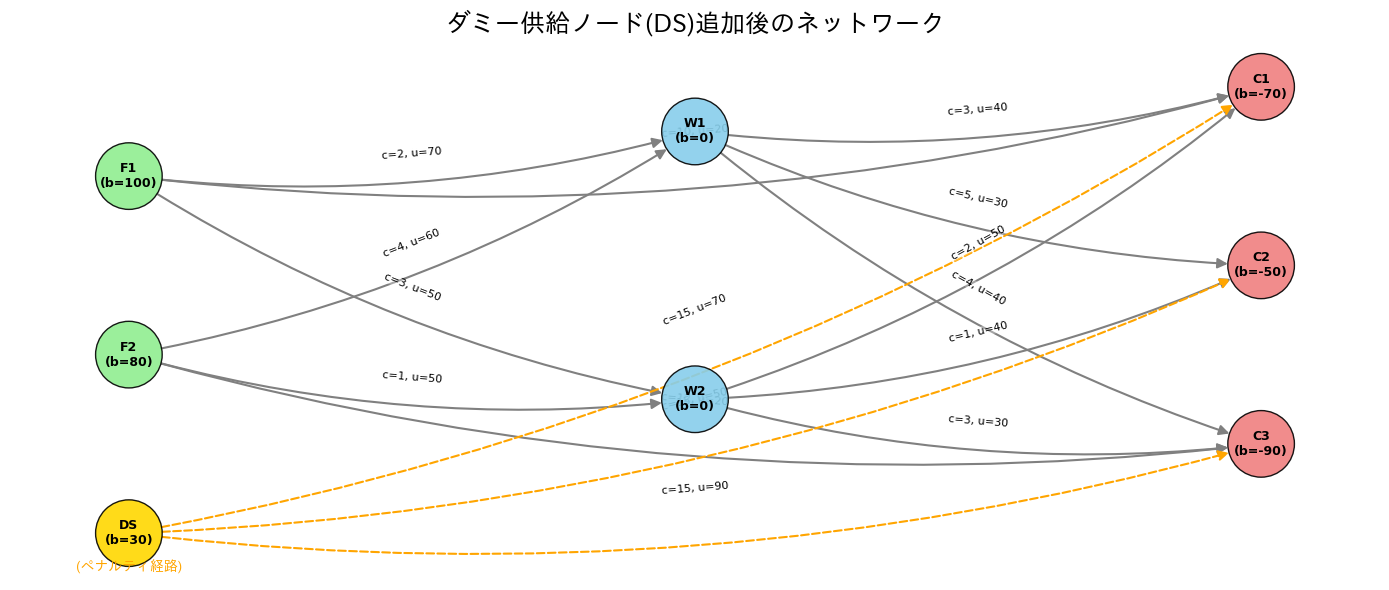

In [ ]:
#@title 図
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np
import pandas as pd # DataFrame表示用 (MIPコードで使用)

# --- ネットワークデータ (応用演習1用) ---
nodes_data_adv1_fig = {
    'F1': {'balance': 100, 'type': 'supply', 'pos': (0, 2.5)},
    'F2': {'balance': 80,  'type': 'supply', 'pos': (0, 0.5)},
    'W1': {'balance': 0,   'type': 'transshipment', 'pos': (2, 3)},
    'W2': {'balance': 0,   'type': 'transshipment', 'pos': (2, 0)},
    'C1': {'balance': -70, 'type': 'demand', 'pos': (4, 3.5)},
    'C2': {'balance': -50, 'type': 'demand', 'pos': (4, 1.5)},
    'C3': {'balance': -90, 'type': 'demand', 'pos': (4, -0.5)}, # 需要変更
    'DS': {'balance': 30,  'type': 'dummy_supply', 'pos': (0, -1.5)} # ダミー供給ノード
}
arcs_data_adv1_fig = [
    # 元のアーク
    ('F1', 'W1', 2, 70), ('F1', 'W2', 3, 50),
    ('F2', 'W1', 4, 60), ('F2', 'W2', 1, 50),
    ('W1', 'C1', 3, 40), ('W1', 'C2', 5, 30), ('W1', 'C3', 4, 40),
    ('W2', 'C1', 2, 50), ('W2', 'C2', 1, 40), ('W2', 'C3', 3, 30),
    ('F1', 'C1', 10, 20),('F2', 'C3', 12, 20),
    # ダミーアーク (費用=ペナルティ15)
    ('DS', 'C1', 15, 70), # 容量は各需要量（またはそれ以上）
    ('DS', 'C2', 15, 50),
    ('DS', 'C3', 15, 90)
]

# グラフオブジェクトの作成
G_adv1_fig = nx.DiGraph()
node_names_adv1_fig = list(nodes_data_adv1_fig.keys())
G_adv1_fig.add_nodes_from(node_names_adv1_fig)

for u, v, cost, capacity in arcs_data_adv1_fig:
    G_adv1_fig.add_edge(u, v, cost=cost, capacity=capacity)

# ノードの描画位置
pos_adv1_fig = {name: data['pos'] for name, data in nodes_data_adv1_fig.items()}

# ノードの色分け
color_map_adv1_fig = []
for node_name in G_adv1_fig.nodes():
    node_type = nodes_data_adv1_fig[node_name]['type']
    if node_type == 'supply': color_map_adv1_fig.append('lightgreen')
    elif node_type == 'demand': color_map_adv1_fig.append('lightcoral')
    elif node_type == 'dummy_supply': color_map_adv1_fig.append('gold')
    else: color_map_adv1_fig.append('skyblue') # transshipment

# 描画
plt.figure(figsize=(14, 6))
node_draw_size_adv1_fig = 2300

nx.draw_networkx_nodes(G_adv1_fig, pos_adv1_fig, node_size=node_draw_size_adv1_fig,
                       node_color=color_map_adv1_fig, alpha=0.9, edgecolors="black")
node_labels_adv1_fig = {name: f"{name}\n(b={data['balance']})" for name, data in nodes_data_adv1_fig.items()}
nx.draw_networkx_labels(G_adv1_fig, pos_adv1_fig, labels=node_labels_adv1_fig, font_size=9, font_weight='bold')

# ダミーアークと通常アークでスタイルを分ける
normal_arcs = [e for e in G_adv1_fig.edges() if e[0] != 'DS']
dummy_arcs = [e for e in G_adv1_fig.edges() if e[0] == 'DS']

nx.draw_networkx_edges(G_adv1_fig, pos_adv1_fig, edgelist=normal_arcs, width=1.5, arrowstyle='-|> ', arrowsize=15,
                       edge_color='gray', connectionstyle='arc3,rad=0.1', node_size=node_draw_size_adv1_fig,
                       min_source_margin=18, min_target_margin=18)
nx.draw_networkx_edges(G_adv1_fig, pos_adv1_fig, edgelist=dummy_arcs, width=1.5, arrowstyle='-|> ', arrowsize=15,
                       edge_color='orange', style='dashed', connectionstyle='arc3,rad=0.1',
                       node_size=node_draw_size_adv1_fig, min_source_margin=18, min_target_margin=18)


edge_labels_adv1_fig = {(u,v): f"c={d['cost']}, u={d['capacity']}" for u,v,d in G_adv1_fig.edges(data=True)}
nx.draw_networkx_edge_labels(G_adv1_fig, pos_adv1_fig, edge_labels=edge_labels_adv1_fig, font_size=8, font_color='black',
                             bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', pad=0.1))

plt.title("ダミー供給ノード(DS)追加後のネットワーク", fontsize=18)
plt.text(pos_adv1_fig['DS'][0], pos_adv1_fig['DS'][1]-0.3, '(ペナルティ経路)', ha='center', va='top', fontsize=10, color='orange')
plt.axis('off')
plt.tight_layout()
plt.show()


###Python (MIP) による実装


In [ ]:
import pandas as pd
from mip import Model, xsum, minimize, CONTINUOUS, OptimizationStatus

# --- データ定義 ---
# 新しいノードDSを追加
node_names = ['F1', 'F2', 'W1', 'W2', 'C1', 'C2', 'C3', 'DS']
# C3の需要を-90に、DSの供給を30に設定
balances = {'F1': 100, 'F2': 80, 'W1': 0, 'W2': 0, 'C1': -70, 'C2': -50, 'C3': -90, 'DS': 30}

# 元のアークデータ
arcs_data = [
    ('F1', 'W1', 2, 70), ('F1', 'W2', 3, 50),
    ('F2', 'W1', 4, 60), ('F2', 'W2', 1, 50),
    ('W1', 'C1', 3, 40), ('W1', 'C2', 5, 30), ('W1', 'C3', 4, 40),
    ('W2', 'C1', 2, 50), ('W2', 'C2', 1, 40), ('W2', 'C3', 3, 30),
    ('F1', 'C1', 10, 20), ('F2', 'C3', 12, 20)
]

# ダミーアークを追加 (費用=ペナルティ15)
# 容量は各需要量に設定
dummy_arcs_data = [
    ('DS', 'C1', 15, 70),
    ('DS', 'C2', 15, 50),
    ('DS', 'C3', 15, 90)
]
all_arcs_data = arcs_data + dummy_arcs_data

defined_arcs = [(u, v) for u, v, cost, cap in all_arcs_data]
costs = {(u, v): cost for u, v, cost, cap in all_arcs_data}
capacities = {(u, v): cap for u, v, cost, cap in all_arcs_data}

# --- モデル作成 ---
model = Model("Infeasible_MCF_with_Penalty")

# --- 決定変数 ---
x = {(i, j): model.add_var(name=f"x_{i}_{j}", lb=0, ub=capacities[i, j], var_type=CONTINUOUS)
     for (i, j) in defined_arcs}

# --- 目的関数 ---
# 輸送費用とペナルティ費用の合計を最小化
model.objective = minimize(xsum(costs[i, j] * x[i, j] for (i, j) in defined_arcs))

# --- 制約条件 ---
for k in node_names:
    model += (xsum(x[i, j] for (i, j) in defined_arcs if i == k) -
              xsum(x[i, j] for (i, j) in defined_arcs if j == k) == balances[k],
              f"FlowBalance_{k}")

# --- 最適化の実行 ---
status = model.optimize()

# --- 結果の表示 ---
if status == OptimizationStatus.OPTIMAL:
    print(f"最適解が見つかりました。")
    print(f"総費用（輸送費 + ペナルティ）: {model.objective_value:.2f}")
    print("\n--- 実際の輸送フロー ---")
    for (i, j) in [(i,j) for i,j,c,p in arcs_data]:
        if x[i, j].x > 1e-6:
            print(f"  アーク ({i} -> {j}): {x[i, j].x:.2f} ユニット")

    print("\n--- 未充足需要（ペナルティ対象） ---")
    penalty_flow = False
    for (i, j) in [(i,j) for i,j,c,p in dummy_arcs_data]:
        if x[i, j].x > 1e-6:
            print(f"  顧客 {j} への不足分: {x[i, j].x:.2f} ユニット")
            penalty_flow = True
    if not penalty_flow:
        print("  なし")

else:
    print(f"最適化が停止しました。ステータス: {status}")

最適解が見つかりました。
総費用（輸送費 + ペナルティ）: 1340.00

--- 実際の輸送フロー ---
  アーク (F1 -> W1): 50.00 ユニット
  アーク (F1 -> W2): 50.00 ユニット
  アーク (F2 -> W1): 30.00 ユニット
  アーク (F2 -> W2): 50.00 ユニット
  アーク (W1 -> C1): 40.00 ユニット
  アーク (W1 -> C3): 40.00 ユニット
  アーク (W2 -> C1): 30.00 ユニット
  アーク (W2 -> C2): 40.00 ユニット
  アーク (W2 -> C3): 30.00 ユニット

--- 未充足需要（ペナルティ対象） ---
  顧客 C2 への不足分: 10.00 ユニット
  顧客 C3 への不足分: 20.00 ユニット
